In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TF

In [2]:
def show_sample_image(data_dir, classes):
    plt.figure(figsize=(15, 3))
    for idx, class_name in enumerate(classes, 1):
        try:
            class_dir = data_dir / class_name
            first_file = next(class_dir.glob('*.jpg'))
            img = Image.open(first_file)
            plt.subplot(1, len(classes), idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        except (StopIteration, FileNotFoundError):
            print(f"No images found in {class_name}")
        except Exception as e:
            print(f"Error with {class_name}: {e}")
    plt.tight_layout()
    plt.show()

In [3]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            # Second Convolution Block
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (img_size // 4) * (img_size // 4), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
 # For applying transforms on subsets

class TransformedDataset(Dataset):

    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.subset)




def prepare_data_loaders(data_dir, img_size, batch_size, validation_split, num_workers=0):
    """
    Fnc. to prepare  with image augmentation
       -train data loaders   &  -validation data loaders

    Args:
        data_dir (Path): Root dir of the dataset.
        img_size (int): Size (height and width) to resize images.
        batch_size (int): # of samples per batch.
        validation_split (float): % split of data-splitting for validation.

    Returns:
        train_loader, val_loader, classes
    """
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.9, 1.1)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        # here could be added eventualy additional rotation
        transforms.RandomRotation(72),
        transforms.ToTensor(),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    full_dataset = ImageFolder(root=str(data_dir))

    # Data Splitting:
    dataset_size = len(full_dataset)
    train_size = int((1 - validation_split) * dataset_size)
    val_size = dataset_size - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])



    train_dataset = TransformedDataset(train_subset, train_transforms)
    val_dataset = TransformedDataset(val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_dataset.classes

In [5]:
# Plotting
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))

    # Accr. plot
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# model Evaluaton  and plot of the confusion matrix.
def evaluate_and_plot_predictions(model, val_loader, classes):
    """
    Args:
        model (nn.Module): The trained CNN model.
        val_loader (DataLoader): DataLoader for the validation set.
        classes (list): List of class names.

    Returns:
        dict: Metrics including accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    total = len(all_labels)
    accuracy = correct / total
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # normalized confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize=None)
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return {'accuracy': accuracy, 'confusion_matrix': cm}

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls "/content/drive/MyDrive/Colab Notebooks"

 blood_cell_images			       ResNet_ver3_Nov5.ipynb
 blood_cell_images_split		       ResNet_ver4_Nov12.ipynb
 blood_cell_images_split_90_10		       Untitled0.ipynb
 custom_CNN_with_PyTorch_ver4_Nov4.ipynb      ' YOLO_ver.2 _Oct_1.ipynb'
 custom_CNN_with_TensorFlow_ver3_Nov12.ipynb   YOLO_ver.5_Oct16.ipynb
 data.yaml				       YOLO_ver.6_Oct22.ipynb
 MiniVGG_ver6_Nov13.ipynb		       YOLO_ver.7_Nov13.ipynb
 pythonProject1				      'YOLO_ver_8_Nov13 .ipynb'
 PyTorch_ver.3_Oct31.ipynb


In [9]:
img_size = 128
batch_size = 32
epochs = 10
validation_split = 0.2
learning_rate = 0.001
patience = 5

classes = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")

train_path = base_dir / "train"
val_path   = base_dir / "val"

model_save_dir = Path("/content/drive/MyDrive/Colab Notebooks/models")

In [10]:
print("Classes found in TRAIN:", os.listdir(train_path))
print("Classes found in VAL:", os.listdir(val_path))

Classes found in TRAIN: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
Classes found in VAL: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


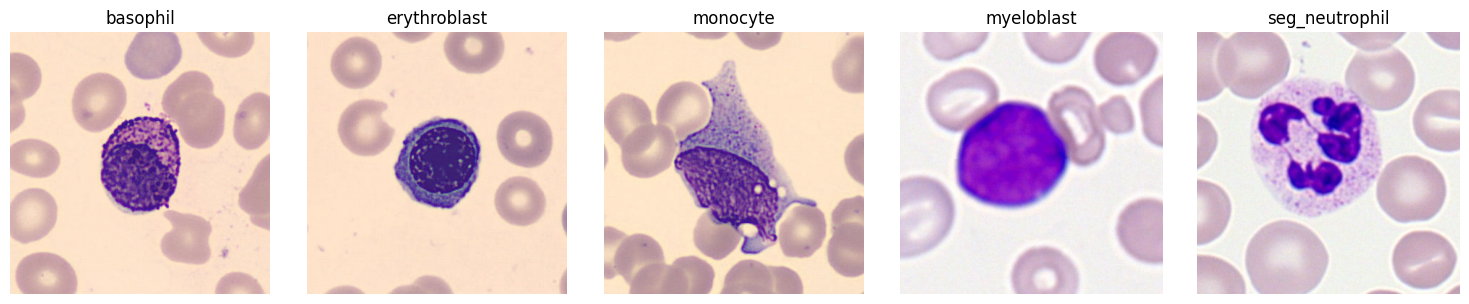

In [11]:
# Show sample images from the dataset
show_sample_image(train_path, classes)

In [12]:
# Data loaders
data_dir = base_dir

train_loader, val_loader, class_names = prepare_data_loaders(
    data_dir=data_dir,
    img_size=img_size,
    batch_size=batch_size,
    validation_split=0.0
)

In [13]:
# Model initialization

model = CNNModel(num_classes=len(class_names), img_size=img_size)
print("Model architecture:")
print(model)

Model architecture:
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)

In [14]:
# Define loss, optimizer, and learning rate scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)

In [15]:
# Tracking variables for training history

best_val_loss = float('inf')
no_improve = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [16]:
def train_one_epoch(model, train_loader, optimizer, criterion):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

In [17]:
def validate_one_epoch(model, val_loader, criterion):

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [18]:
def save_best_model(model, model_save_dir, val_loss, best_val_loss):

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save_dir.mkdir(exist_ok=True)
        torch.save(model.state_dict(), model_save_dir / 'best_model.pth')
    return best_val_loss

In [19]:
def print_epoch_results(epoch, epochs, train_loss, train_acc, val_loss, val_acc):

    print(f"Epoch {epoch + 1}/{epochs}", flush=True)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

In [20]:
def early_stopping_check(val_loss, best_val_loss, no_improve, patience):

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered!")
            return True, best_val_loss, no_improve

    return False, best_val_loss, no_improve

In [21]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, patience, model_save_dir):
    best_val_loss = float('inf')
    no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print_epoch_results(epoch, epochs, train_loss, train_acc, val_loss, val_acc)

        best_val_loss = save_best_model(model, model_save_dir, val_loss, best_val_loss)

        # stop_training, best_val_loss, no_improve = early_stopping_check(val_loss, best_val_loss, no_improve, patience)
        # if stop_training:
        #     break

    return train_losses, val_losses, train_accs, val_accs

In [22]:
val_path = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/val")
for cls in val_path.iterdir():
    print(cls.name, len(list(cls.iterdir())))

basophil 100
erythroblast 100
monocyte 100
myeloblast 100
seg_neutrophil 100


In [23]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(data_dir / "train", transform=transform)
val_dataset   = ImageFolder(data_dir / "val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Number of train batches:", len(train_loader))
print("Number of val batches:", len(val_loader))

Number of train batches: 143
Number of val batches: 16


In [24]:
img_size = 128
batch_size = 32
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(data_dir / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(data_dir / "val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))
print(type(x), x.shape)

<class 'torch.Tensor'> torch.Size([32, 3, 128, 128])


In [26]:
import os
from PIL import Image, UnidentifiedImageError

base_dir = "/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10"

bad_files = []

for root, _, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(root, f)
            try:
                with Image.open(path) as img:
                    img.verify()  # Check if it's readable
            except (UnidentifiedImageError, OSError):
                bad_files.append(path)

print(f"Found {len(bad_files)} corrupted images.")

for bf in bad_files:
    print("Removing:", bf)
    os.remove(bf)

Found 1 corrupted images.
Removing: /content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/train/basophil/BA_511856.jpg


In [27]:
# Hyperparameters and training settings
img_size = 128
batch_size = 32
epochs = 10
validation_split = 0.0
learning_rate = 0.001
patience = 5
classes = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
model_save_dir = Path("models")

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(data_dir / "train", transform=transform)
val_dataset   = ImageFolder(data_dir / "val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = classes

print("Number of batches in val_loader:", len(val_loader))

model = CNNModel(num_classes=len(class_names), img_size=img_size)
print("Model architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, optimizer, criterion, scheduler, epochs, patience, model_save_dir
)

Number of batches in val_loader: 16
Model architecture:
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_fea

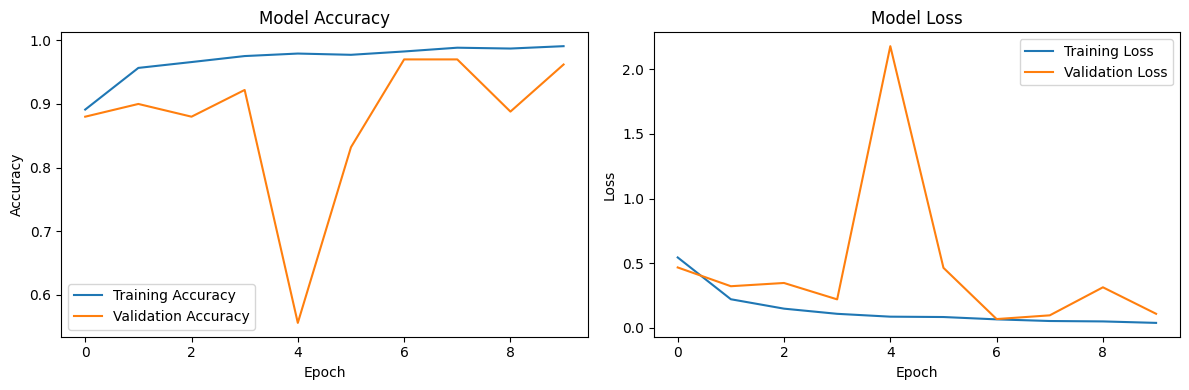

In [28]:
# Plot training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

In [29]:
from sklearn.metrics import classification_report


Validation Accuracy: 0.9620


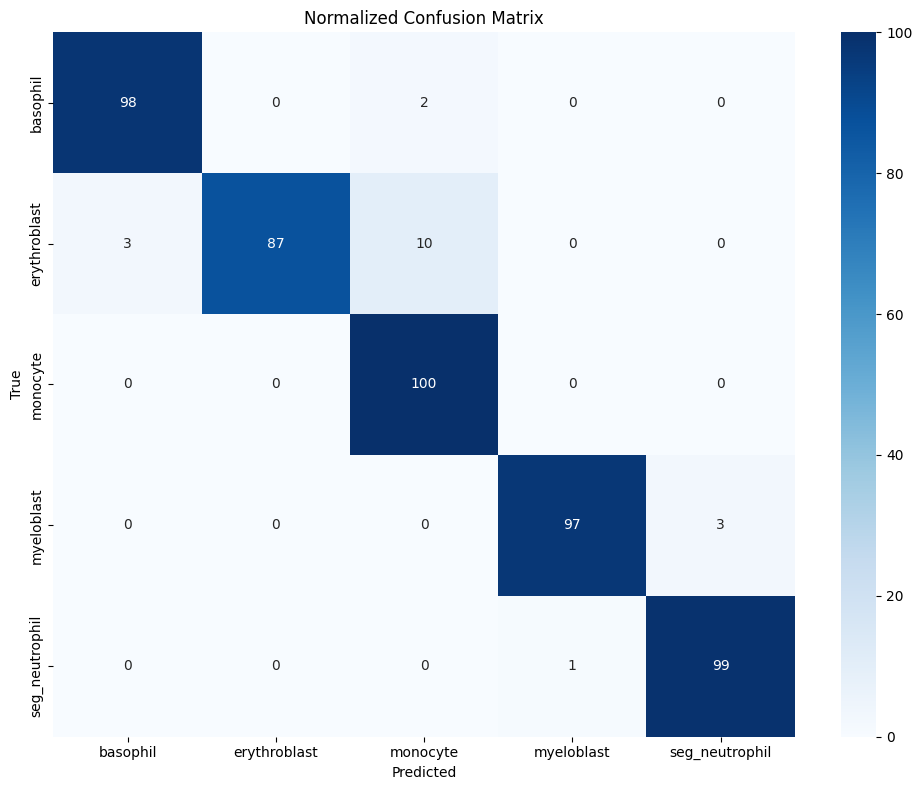

Evaluation Metrics: {'accuracy': np.float64(0.962), 'confusion_matrix': array([[ 98,   0,   2,   0,   0],
       [  3,  87,  10,   0,   0],
       [  0,   0, 100,   0,   0],
       [  0,   0,   0,  97,   3],
       [  0,   0,   0,   1,  99]])}


In [30]:
# Evaluate the model and plot confusion matrix
metrics = evaluate_and_plot_predictions(model, val_loader, class_names)

print("Evaluation Metrics:", metrics)

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [32]:
def evaluate_and_plot_predictions(model, val_loader, classes):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)

            if labels.ndim > 1 and labels.shape[1] > 1:
                labels = labels.argmax(dim=1)

            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Accuracy
    accuracy = (all_preds == all_labels).mean()
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Metrics
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print("\nOverall Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # ROC curve
    num_classes = len(classes)
    y_true_bin = label_binarize(all_labels, classes=range(num_classes))

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

    for i, color in zip(range(num_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve per Class')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }


Validation Accuracy: 0.9620

Overall Metrics:
Precision: 0.9647
Recall:    0.9620
F1-score:  0.9618


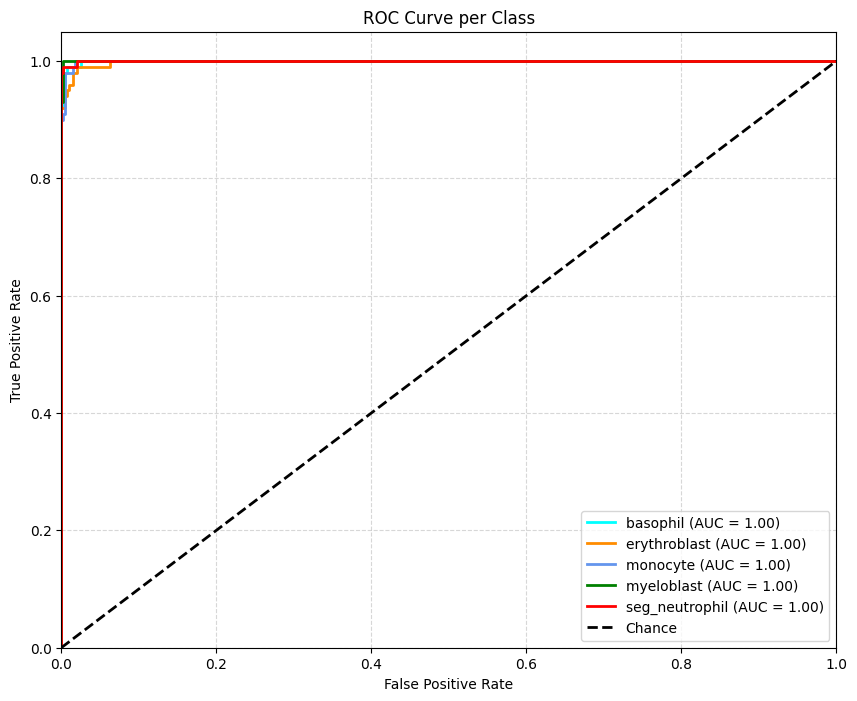

{'accuracy': np.float64(0.962), 'precision': 0.9647076652443156, 'recall': 0.9620000000000001, 'f1_score': 0.9617995775093935, 'confusion_matrix': array([[ 98,   0,   2,   0,   0],
       [  3,  87,  10,   0,   0],
       [  0,   0, 100,   0,   0],
       [  0,   0,   0,  97,   3],
       [  0,   0,   0,   1,  99]])}


In [33]:
metrics = evaluate_and_plot_predictions(model, val_loader, classes)
print(metrics)